# 作業：調整 Bert 模型的訓練參數
- BERT: [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)
- 參考莫煩Python - [BERT 雙向語言模型](https://mofanpy.com/tutorials/machine-learning/nlp/bert/)，並將 Tensorflow 版本改用 PyTorch 實作
***

## [作業目標]
- 調整 Bert 模型的參數, 觀察 loss 數據並比較

## [參數說明]
- MODEL_DIM : Attention 特徵維度
- N_LAYER : Attention 層數
- LEARNING_RATE : 學習速率，影響收斂的快慢
- MASK_RATE : 遮罩比例(介於 0 ~ 0.5 之間, 建議值 0.15)

In [1]:
import os
import time
import pickle
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import utils  # this refers to utils.py in https://github.com/MorvanZhou/NLP-Tutorials

In [2]:
class MultiHead(nn.Module):
    def __init__(self, n_head, model_dim, drop_rate):
        super(MultiHead, self).__init__()
        self.n_head = n_head
        self.model_dim = model_dim
        self.head_dim = model_dim // n_head

        self.wq = nn.Linear(model_dim, n_head * self.head_dim)
        self.wk = nn.Linear(model_dim, n_head * self.head_dim)
        self.wv = nn.Linear(model_dim, n_head * self.head_dim)
        self.o_dense = nn.Linear(model_dim, model_dim)
        self.o_drop = nn.Dropout(drop_rate)

    def forward(self, q, k, v, mask):
        # (batch_size, timestep, n_head * hidden_dim)
        _q, _k, _v = self.wq(q), self.wk(k), self.wv(v)
        # (batch_size, n_head, timestep, hidden_dim)
        _q, _k, _v = self.split_heads(_q), self.split_heads(_k), self.split_heads(_v)
        # (batch_size, timestep, n_head * hidden_dim)
        context = self.scaled_dot_product_attention(_q, _k, _v, mask)
        # (batch_size, timestep, n_head * hidden_dim)
        o = self.o_drop(self.o_dense(context))

        return o

    def split_heads(self, x):
        # (batch_size, timestep, n_head, hidden_dim)
        x = x.view(x.size(0), x.size(1), self.n_head, self.head_dim)
        # (batch_size, n_head, timestep, hidden_dim)
        x = x.permute(0, 2, 1, 3)
        
        return x

    def scaled_dot_product_attention(self, q, k, v, mask=None):
        dk = float(k.size(-1))

        # (batch_size, hidden_dim, timestep, timestep)
        score = torch.matmul(q, k.permute(0, 1, 3, 2)) / (dk ** 0.5)
        if mask is not None:
            score += mask * -1e9
        # (batch_size, n_head, timestep, timestep)
        self.attention = torch.softmax(score, dim=-1)
        # (batch_size, n_head, timestep, hidden_dim)
        context = torch.matmul(self.attention, v)
        # (batch_size, timestep, n_head, hidden_dim)
        context = context.permute(0, 2, 1, 3).contiguous()
        # (batch_size, timestep, n_head * hidden_dim)
        context = context.view(q.size(0), -1, self.model_dim)

        return context

class PositionWiseFFN(nn.Module):
    def __init__(self, model_dim):
        super(PositionWiseFFN, self).__init__()
        dff = model_dim * 4

        self.l = nn.Linear(model_dim, dff)
        self.o = nn.Linear(dff, model_dim)

    def forward(self, x):
        o = self.o(torch.relu(self.l(x)))  # (batch_size, timestep, hidden_dim)

        return o

class EncodeLayer(nn.Module):
    def __init__(self, n_head, model_dim, drop_rate):
        super(EncodeLayer, self).__init__()
        self.ln = nn.ModuleList([
            nn.LayerNorm(model_dim) for _ in range(2)]  # only norm z-dim
        )
        self.mh = MultiHead(n_head, model_dim, drop_rate)
        self.ffn = PositionWiseFFN(model_dim)
        self.drop = nn.Dropout(drop_rate)

    def forward(self, xz, mask):
        attn = self.mh(xz, xz, xz, mask)  # (batch_size, timestep, hidden_dim)
        o1 = self.ln[0](attn + xz)
        ffn = self.drop(self.ffn(o1))
        o = self.ln[1](ffn + o1)  # (batch_size, timestep, hidden_dim)

        return o

class Encoder(nn.Module):
    def __init__(self, n_head, model_dim, drop_rate, n_layer):
        super(Encoder, self).__init__()
        self.ls = nn.ModuleList([
            EncodeLayer(n_head, model_dim, drop_rate) for _ in range(n_layer)
        ])

    def forward(self, xz, mask):
        for l in self.ls:
            xz = l(xz, mask)  # (batch_size, timestep, hidden_dim)

        return xz

class BERT(nn.Module):
    def __init__(self, model_dim, max_len, n_layer, n_head, n_vocab, 
                 max_seg=3, drop_rate=0.1, padding_idx=0):
        super(BERT, self).__init__()
        self.padding_idx = padding_idx

        self.word_emb = nn.Embedding(n_vocab, model_dim)
        nn.init.normal_(self.word_emb.weight, 0, 0.01)
        self.segment_emb = nn.Embedding(max_seg, model_dim)
        nn.init.normal_(self.segment_emb.weight, 0, 0.01)
        self.position_emb = nn.Parameter(torch.empty(1, max_len, model_dim))
        nn.init.normal_(self.position_emb, 0, 0.01)
        self.encoder = Encoder(n_head, model_dim, drop_rate, n_layer)
        self.task_mlm = nn.Linear(model_dim, n_vocab)
        self.task_nsp = nn.Linear(model_dim, 2)

        self.mlm_cross_entropy = nn.CrossEntropyLoss(reduction='none')
        self.nsp_cross_entropy = nn.CrossEntropyLoss()

    def forward(self, seqs, segs):
        embed = self.input_emb(seqs, segs)  # (batch_size, timestep, hidden_dim)
        z = self.encoder(embed, mask=self.mask(seqs))  # (batch_size, timestep, hidden_dim)
        pooled = z[:, 1, :]  # (batch_size, 1, hidden_dim)
        mlm_logits = self.task_mlm(z)  # (batch_size, timestep, n_vocab)
        nsp_logits = self.task_nsp(pooled.view(pooled.size(0), -1))  #(batch_size, n_cls)

        return mlm_logits, nsp_logits

    def input_emb(self, seqs, segs):
        # (batch_size, timestep, hidden_dim)
        emb = self.word_emb(seqs) + self.segment_emb(segs) + self.position_emb

        return emb

    def cal_loss(self, seqs, segs, seqs_, loss_mask, nsp_labels):
        mlm_logits, nsp_logits = self.forward(seqs, segs)

        mlm_loss_batch = torch.masked_select(
            self.mlm_cross_entropy(mlm_logits.view(-1, mlm_logits.size(-1)), seqs_.view(-1)),
            loss_mask.view(-1).bool()
        )
        mlm_loss = torch.mean(mlm_loss_batch)
        nsp_loss = self.nsp_cross_entropy(nsp_logits.view(-1, nsp_logits.size(-1)), 
                                          nsp_labels.view(-1))
        loss = mlm_loss + 0.2 * nsp_loss
    
        return loss, mlm_logits

    def mask(self, seqs):
        mask = seqs == self.padding_idx
        mask = mask.view(mask.size(0), 1, 1, mask.size(-1))  # (batch_size, 1, 1, timestpe)
        
        return mask

    @property
    def attentions(self):
        attentions = {
            'encoder': [l.mh.attention.cpu().detach().numpy() for l in self.encoder.ls]
        }

        return attentions

In [3]:
def _get_loss_mask(len_arange, seq, pad_id):
    rand_id = np.random.choice(len_arange, size=max(2, int(MASK_RATE * len(len_arange))), replace=False)
    loss_mask = np.full_like(seq, pad_id, dtype=np.bool)
    loss_mask[rand_id] = True

    return loss_mask[None, :], rand_id

def do_mask(seq, len_arange, pad_id, mask_id):
    loss_mask, rand_id = _get_loss_mask(len_arange, seq, pad_id)
    seq[rand_id] = mask_id

    return loss_mask

def do_replace(seq, len_arange, pad_id, word_ids):
    loss_mask, rand_id = _get_loss_mask(len_arange, seq, pad_id)
    seq[rand_id] = np.random.choice(word_ids, size=len(rand_id))

    return loss_mask

def do_nothing(seq, len_arange, pad_id):
    loss_mask, _ = _get_loss_mask(len_arange, seq, pad_id)

    return loss_mask

def random_mask_or_replace(data, arange, batch_size):
    seqs, segs, xlen, nsp_labels = data.sample(batch_size)
    seqs_ = seqs.copy()
    p = np.random.random()
    if p < 0.7:
        # mask
        loss_mask = np.concatenate(
            [do_mask(
                seqs[i],
                np.concatenate((arange[:xlen[i, 0]], arange[xlen[i, 0] + 1:xlen[i].sum() + 1])),
                data.pad_id,
                data.v2i["<MASK>"]) for i in range(len(seqs))], axis=0)
    elif p < 0.85:
        # do nothing
        loss_mask = np.concatenate(
            [do_nothing(
                seqs[i],
                np.concatenate((arange[:xlen[i, 0]], arange[xlen[i, 0] + 1:xlen[i].sum() + 1])),
                data.pad_id) for i in range(len(seqs))], axis=0)
    else:
        # replace
        loss_mask = np.concatenate(
            [do_replace(
                seqs[i],
                np.concatenate((arange[:xlen[i, 0]], arange[xlen[i, 0] + 1:xlen[i].sum() + 1])),
                data.pad_id,
                data.word_ids) for i in range(len(seqs))], axis=0)

    return seqs, segs, seqs_, loss_mask, xlen, nsp_labels

In [4]:
def train(model, data, batch_size, step, optimizer, device):
    start_time = time.time()
    arange = np.arange(0, data.max_len)
    for t in range(step):
        batch = random_mask_or_replace(data, arange, batch_size)
        seqs, segs, seqs_, loss_mask, xlen, nsp_labels = [torch.LongTensor(x).to(device) for x in batch]
        loss, pred = model.cal_loss(seqs, segs, seqs_, loss_mask, nsp_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if t % 100 == 0:
            pred = torch.argmax(pred[0], dim=1)
            end_time = time.time()
            print(
                f"step: {t} | time: {end_time - start_time:.2f} | loss: {loss.item():.3f}\n",
                f"| tgt: {' '.join([data.i2v[i] for i in seqs[0][:xlen[0].sum() + 1].tolist() if i != data.pad_id])}\n",
                f"| prd: {' '.join([data.i2v[i] for i in pred[:xlen[0].sum() + 1].tolist()])}\n",
                f"| tgt word: {[data.i2v[i] for i in (seqs_[0] * loss_mask[0]).tolist() if i != data.v2i['<PAD>']]}\n",
                f"| prd word: {[data.i2v[i] for i in (pred * loss_mask[0]).tolist() if i != data.v2i['<PAD>']]}\n\n"
            )
            start_time = end_time
    os.makedirs('models', exist_ok=True)
    torch.save(model, os.path.join('models', 'bert.pt'))

In [5]:
def export_attention(model, data):
    model = torch.load(os.path.join('models', 'bert.pt'), map_location=device)

    # save attention matrix for visualization
    batch = data.sample(32)
    seqs, segs, xlen, nsp_labels = [torch.LongTensor(x).to(device) for x in batch]
    model(seqs, segs)
    data = {'src': [[data.i2v[i] for i in seqs[j].tolist()] for j in range(len(seqs))],
            'attentions': model.attentions}

    save_path = 'attention_matrix.pkl'
    with open(save_path, 'wb') as f:
        pickle.dump(data, f)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 16
MODEL_DIM = 256
N_LAYER = 4
LEARNING_RATE = 3e-4
MASK_RATE = 0.15

data = utils.MRPCData('MRPC', rows=2000)
print('num word:', data.num_word)

num word: 12880


In [7]:
model = BERT(
    model_dim=MODEL_DIM, max_len=data.max_len, n_layer=N_LAYER, n_head=4, n_vocab=data.num_word,
    max_seg=data.num_seg, drop_rate=0.2, padding_idx=data.v2i["<PAD>"]
).to(device)
model

BERT(
  (word_emb): Embedding(12880, 256)
  (segment_emb): Embedding(3, 256)
  (encoder): Encoder(
    (ls): ModuleList(
      (0): EncodeLayer(
        (ln): ModuleList(
          (0): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        )
        (mh): MultiHead(
          (wq): Linear(in_features=256, out_features=256, bias=True)
          (wk): Linear(in_features=256, out_features=256, bias=True)
          (wv): Linear(in_features=256, out_features=256, bias=True)
          (o_dense): Linear(in_features=256, out_features=256, bias=True)
          (o_drop): Dropout(p=0.2, inplace=False)
        )
        (ffn): PositionWiseFFN(
          (l): Linear(in_features=256, out_features=1024, bias=True)
          (o): Linear(in_features=1024, out_features=256, bias=True)
        )
        (drop): Dropout(p=0.2, inplace=False)
      )
      (1): EncodeLayer(
        (ln): ModuleList(
          (0): LayerNorm((256,)

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
train(model, data, BATCH_SIZE, 10000, optimizer, device)

step: 0 | time: 0.05 | loss: 9.757
 | tgt: <GO> <MASK> kozlowski <MASK> that the event included business <MASK> that some <MASK> those attending were tyco employees . <SEP> mr. kozlowski contends that the event was in large part a business function
 | prd: sensenbrenner crash vizcaino sunnis vizcaino imir markets vizcaino memories imir tainted publications extended pneumonia forrester memories memories markets station memories crash vizcaino operate memories vizcaino sessions memories boom vizcaino vizcaino arthur vizcaino crash
 | tgt word: ['mr.', 'contends', 'and', 'of']
 | prd word: ['crash', 'sunnis', 'imir', 'extended']


step: 100 | time: 2.99 | loss: 7.216
 | tgt: <GO> the downtime , to take place in may and june , is expected to cut production by <NUM> million to <NUM> million board feet . <SEP> the downtime is expected to take <NUM> million to <NUM> million board feet out of the companys system
 | prd: <GO> the the the the the , the , , the the , the the the the , the , , the

In [9]:
export_attention(model, data)

In [10]:
# this refers to visual.py in https://github.com/MorvanZhou/NLP-Tutorials
def self_attention_line(case=0):
    with open('attention_matrix.pkl', 'rb') as f:
        data = pickle.load(f)
    src = data['src'][case]
    attentions = data['attentions']
    encoder_atten = attentions['encoder']

    print(' '.join(src))
    s_len = 0
    for s in src:
        if s == '<SEP>':
            break
        s_len += 1
    y_label = src[:s_len][::-1]
    fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(8, 16))

    for i in range(2):
        for j in range(2):
            ax[i, j].set_yticks(np.arange(len(y_label)))
            ax[i, j].tick_params(labelright=True)
            ax[i, j].set_yticklabels(y_label, fontsize=10)  # input

            img = encoder_atten[-1][case, i + j][:s_len - 1, :s_len - 1]
            color = cm.rainbow(np.linspace(0, 1, img.shape[0]))
            for row, c in zip(range(img.shape[0]), color):
                for col in range(img.shape[1]):
                    alpha = (img[row, col] / img[row].max()) ** 5
                    ax[i, j].plot([0, 1], [img.shape[1] - col, img.shape[0] - row - 1], 
                                  alpha=alpha, c=c)
            ax[i, j].set_xticks(())
            ax[i, j].set_xlabel(f"head {j + 1 + i * 2}")
            ax[i, j].set_xlim(0, 1)
    plt.subplots_adjust(top=0.9)
    plt.tight_layout()
    plt.savefig('self_attention_line.png', dpi=100)

<GO> rambus inc . ( nasdaq : rmbs - news - people ) shot up <NUM> percent , making it the biggest percentage gainer on the nasdaq . <SEP> rambus inc. shot up almost <NUM> percent , making it the biggest percentage gainer on the nasdaq . <SEP> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


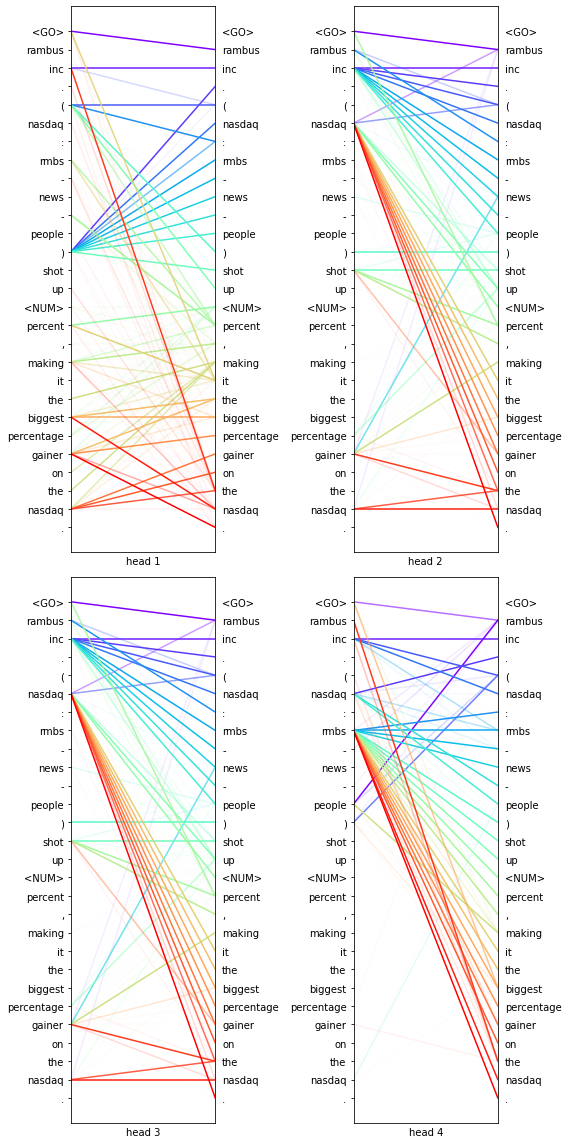

In [11]:
self_attention_line(case=0)